# Overview
The primary goal of this competition is identification and segmentation of surface defects in flat sheet steel. In contrast to previous segmentation competitions, such as [Airbus Ship Detection Challenge](https://www.kaggle.com/c/airbus-ship-detection/discussion) and [TGS Salt Identification Challenge](https://www.kaggle.com/c/tgs-salt-identification-challenge), as well as the ongoing [SIIM-ACR Pneumothorax Segmentation](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation) challenge, here there are several classes of defects must be predicted. The kernel below provides a Unet starter code written with use of fast.ai library and incorporation of Hypercolumns method. Additional details of this method could be found in [this kernel](https://www.kaggle.com/iafoss/hypercolumns-pneumothorax-fastai-0-831-lb). 

In contrast to Pneumothorax challenge, where segmentation may require information from entire image, here surface defects can be identified locally. Therefore, splitting of images into crops and training only on images with nonzero masks may be an effective strategy. In particular, it allows to train the model with using large enough batches and keeping only parts of images containing useful information. Hard negative examples identified based on the model prediction on crops with empty masks are essential for training, and the training set is composed of positive examples, images with texture, and 12000 most difficult negative crops. Despite training is done on crops, the predictions are generated based on full size test images ([check this kernel](https://www.kaggle.com/iafoss/severstal-fast-ai-256x256-crops-sub)). Though, the model could be fine-tuned on full 256x1600 images to further boost the performance. Such an approach was successfully used in [6th place solution](https://www.kaggle.com/c/airbus-ship-detection/discussion/71782#latest-558831) in Ship Detection challenge. Therefore, the train/val split is done based on full images (avoid sharing crops between train and val). The dataset for this kernel with 256x256 crops containing defects is prepared [here](https://www.kaggle.com/iafoss/256x256-images-with-defects). That kernel also provides function for RLE from/to masks conversion, generates masks, and computes the pixel statistics. Because of the 1-hour time limit in the submission kernel (20 min for prediction on the public portion of the test set), I wrote a [separate kernel](https://www.kaggle.com/iafoss/severstal-fast-ai-256x256-crops-sub) for generation of the submission based on models trained here.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
import gc
import os
from sklearn.model_selection import KFold
from PIL import Image
import zipfile
import io
import cv2
import warnings
from radam import RAdam
warnings.filterwarnings("ignore")

fastai.__version__

'1.0.57'

In [2]:
sz = 256
bs = 16
nfolds = 2
fold = 1
SEED = 21
TRAIN = '../input/severstal-256x256-images-with-defects/images/'
MASKS = '../input/severstal-256x256-images-with-defects/masks/'
TRAIN_N = '../input/severstal-256x256-images-with-defects/images_n/'
HARD_NEGATIVE = '../input/hard-negative-severstal-crops/pred.csv'

# copy pretrained weights for resnet34 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet34/resnet34.pth' '/tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)
torch.backends.cudnn.benchmark = True

# Model

In [3]:
#the code below modifies fast.ai functions to incorporate Hcolumns into fast.ai Dynamic Unet

from fastai.vision.learner import create_head, cnn_config, num_features_model, create_head
from fastai.callbacks.hooks import model_sizes, hook_outputs, dummy_eval, Hook, _hook_inner
from fastai.vision.models.unet import _get_sfs_idxs, UnetBlock

class Hcolumns(nn.Module):
    def __init__(self, hooks:Collection[Hook], nc:Collection[int]=None):
        super(Hcolumns,self).__init__()
        self.hooks = hooks
        self.n = len(self.hooks)
        self.factorization = None 
        if nc is not None:
            self.factorization = nn.ModuleList()
            for i in range(self.n):
                self.factorization.append(nn.Sequential(
                    conv2d(nc[i],nc[-1],3,padding=1,bias=True),
                    conv2d(nc[-1],nc[-1],3,padding=1,bias=True)))
                #self.factorization.append(conv2d(nc[i],nc[-1],3,padding=1,bias=True))
        
    def forward(self, x:Tensor):
        n = len(self.hooks)
        out = [F.interpolate(self.hooks[i].stored if self.factorization is None
            else self.factorization[i](self.hooks[i].stored), scale_factor=2**(self.n-i),
            mode='bilinear',align_corners=False) for i in range(self.n)] + [x]
        return torch.cat(out, dim=1)

class DynamicUnet_Hcolumns(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, blur:bool=False, blur_final=True, 
                 self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        self.hc_hooks = [Hook(layers[-1], _hook_inner, detach=False)]
        hc_c = [x.shape[1]]
        
        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, 
                blur=blur, self_attention=sa, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)
            self.hc_hooks.append(Hook(layers[-1], _hook_inner, detach=False))
            hc_c.append(x.shape[1])

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        hc_c.append(ni)
        layers.append(Hcolumns(self.hc_hooks, hc_c))
        layers += [conv_layer(ni*len(hc_c), n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
            
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
        norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, 
        blur:bool=False, self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, 
        last_cross:bool=True, bottle:bool=False, cut:Union[int,Callable]=None, 
        hypercolumns=True, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    M = DynamicUnet_Hcolumns if hypercolumns else DynamicUnet
    model = to_device(M(body, n_classes=data.c, blur=blur, blur_final=blur_final,
        self_attention=self_attention, y_range=y_range, norm_type=norm_type, 
        last_cross=last_cross, bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

The function below computes multiclass dice averaged for each image-class pair. This metric is used in the competition, though one should not be confused with the val score in this kernel and the model performance on the public LB. In particular, images used in training are represented by only a part of all crops (positive examples + images with texture + 12000 hard negative examples).

In [4]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n,c = targs.shape[0], input.shape[1]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect,union = [],[]
    for i in range(1,c):
        intersect.append(((input==i) & (targs==i)).sum(-1).float())
        union.append(((input==i).sum(-1) + (targs==i).sum(-1)).float())
    intersect = torch.stack(intersect)
    union = torch.stack(union)
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

# Data

In [5]:
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

def open_mask(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=ImageSegment,
        after_open:Callable=None)->ImageSegment:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        #generate empty mask if file doesn't exist
        x = PIL.Image.open(fn).convert(convert_mode) \
          if Path(fn).exists() \
          else PIL.Image.fromarray(np.zeros((sz,sz)).astype(np.uint8))
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    return cls(x)

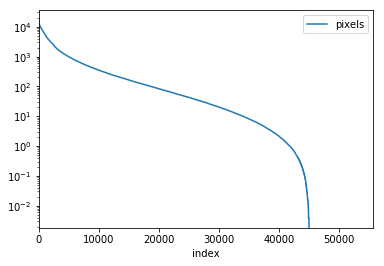

In [6]:
df = pd.read_csv(HARD_NEGATIVE)
df['index'] = df.index
df.plot(x='index', y='pixels', kind = 'line');
plt.yscale('log')

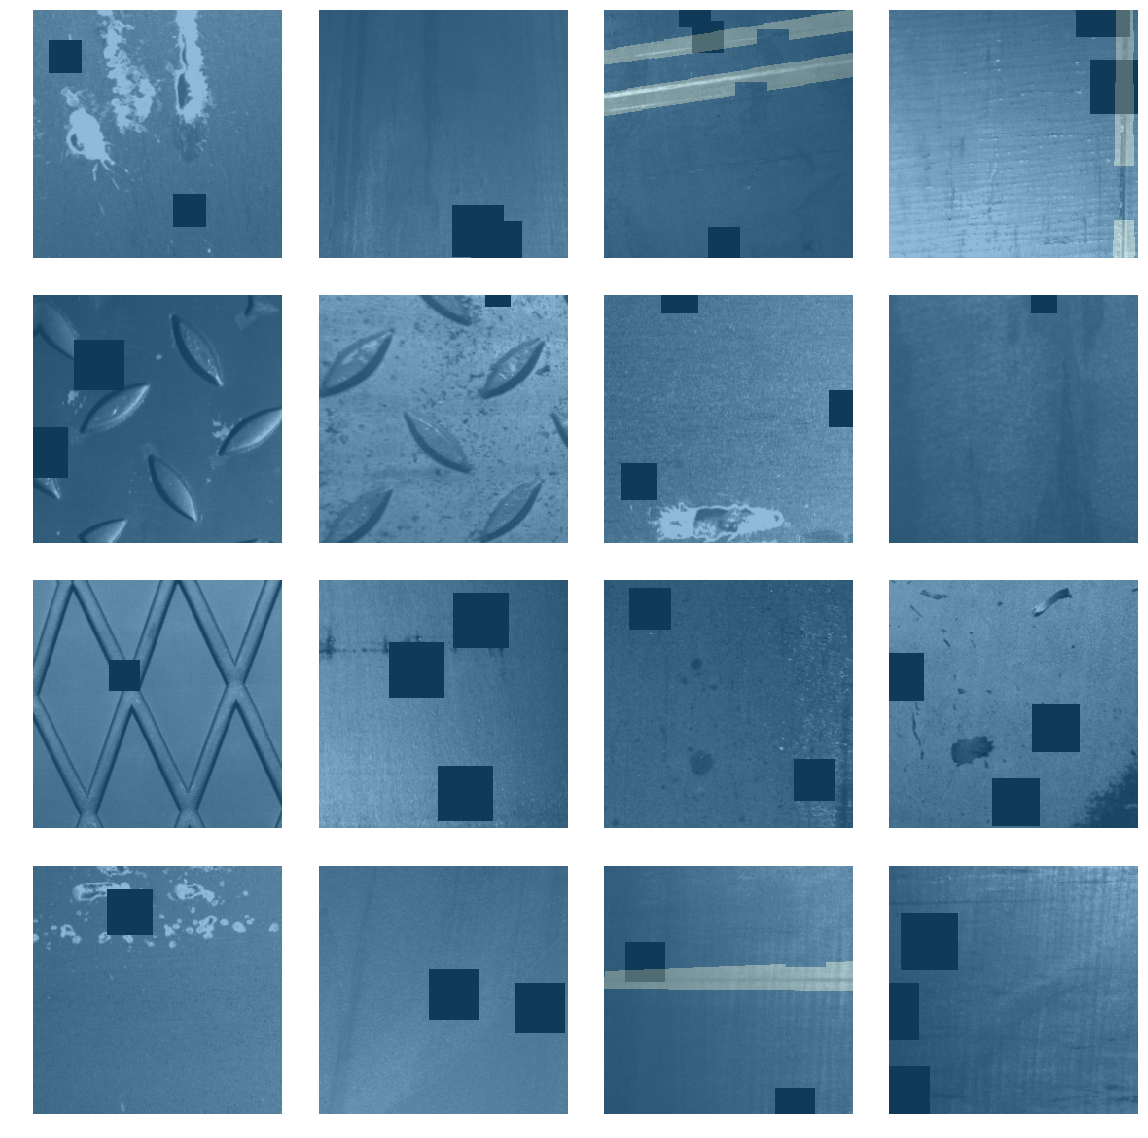

In [7]:
stats = ([0.396,0.396,0.396], [0.179,0.179,0.179])
#check https://www.kaggle.com/iafoss/256x256-images-with-defects for stats

#the code below eliminates sharing patches of the same image across folds
img_p = set([p.stem[:-2] for p in Path(TRAIN).ls()])
#select 12000 of the most difficult negative exaples
neg = list(pd.read_csv(HARD_NEGATIVE).head(12000).fname)
neg = [Path(TRAIN_N)/f for f in neg]
img_n = set([p.stem for p in neg])
img_set = img_p | img_n
img_p_list = sorted(img_p)
img_n_list = sorted(img_n)
img_list = img_p_list + img_n_list
kf = KFold(n_splits=nfolds, shuffle=True, random_state=SEED)

def get_data(fold):
    #split with making sure that crops of the same original image 
    #are not shared between folds, so additional training and validation 
    #could be done on full images later
    valid_idx = list(kf.split(list(range(len(img_list)))))[fold][1]
    valid = set([img_list[i] for i in valid_idx])
    valid_idx = []
    for i,p in enumerate(Path(TRAIN).ls() + neg):
        if p.stem[:-2] in valid: valid_idx.append(i)
            
    # Create databunch
    sl = SegmentationItemList.from_folder(TRAIN)
    sl.items = np.array((list(sl.items) + neg))
    data = (sl.split_by_idx(valid_idx)
        .label_from_func(lambda x : str(x).replace('/images', '/masks'), classes=[0,1,2,3,4])
        .transform(get_transforms(max_lighting=0.3, max_warp=0.1, xtra_tfms=[dihedral(), cutout(n_holes=(1,3), length=(20, 60), p=1)]), size=sz, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize(stats))
    return data

# Display some images with masks
get_data(0).show_batch()

In [8]:
@dataclass
class CSVLogger(LearnerCallback):
    def __init__(self, learn, filename= 'history'):
        self.learn = learn
        self.path = self.learn.path/f'{filename}.csv'
        self.file = None

    @property
    def header(self):
        return self.learn.recorder.names

    def read_logged_file(self):
        return pd.read_csv(self.path)

    def on_train_begin(self, metrics_names: StrList, **kwargs: Any) -> None:
        self.path.parent.mkdir(parents=True, exist_ok=True)
        e = self.path.exists()
        self.file = self.path.open('a')
        if not e: self.file.write(','.join(self.header) + '\n')

    def on_epoch_end(self, epoch: int, smooth_loss: Tensor, last_metrics: MetricsList, **kwargs: Any) -> bool:
        self.write_stats([epoch, smooth_loss] + last_metrics)

    def on_train_end(self, **kwargs: Any) -> None:
        self.file.flush()
        self.file.close()

    def write_stats(self, stats: TensorOrNumList) -> None:
        stats = [str(stat) if isinstance(stat, int) else f'{stat:.6f}'
                 for name, stat in zip(self.header, stats)]
        str_stats = ','.join(stats)
        self.file.write(str_stats + '\n')

The function below generates predictions with 3 fold TTA (horizontal flip, vertical flip, and both). The default fast.ai implementation is too memory hungry since predictions for all images and TTA folds are kept in memory. So it becomes hardly possible to generate a prediction for a reasonable number of high resolution images.

In [9]:
# Prediction with flip TTA
def model_pred(learn:fastai.basic_train.Learner,F_save,
        ds_type:fastai.basic_data.DatasetType=DatasetType.Valid, 
        tta:bool=True): #if use train dl, disable shuffling
    learn.model.eval();
    dl = learn.data.dl(ds_type)
    #sampler = dl.batch_sampler.sampler
    #dl.batch_sampler.sampler = torch.utils.data.sampler.SequentialSampler(sampler.data_source)
    name_list = [Path(n).stem for n in dl.dataset.items]
    num_batchs = len(dl)
    t = progress_bar(iter(dl), leave=False, total=num_batchs)
    count = 0
    with torch.no_grad():
        for x,y in t:
            x = x.cuda()
            py = torch.softmax(learn.model(x),dim=1).permute(0,2,3,1).detach()
            if tta:
                flips = [[-1],[-2],[-2,-1]]
                for f in flips:
                    py += torch.softmax(torch.flip(learn.model(torch.flip(x,f)),f),dim=1)\
                      .permute(0,2,3,1).detach()
                py /= (1+len(flips))
            py = py.cpu().numpy()
            batch_size = len(py)
            for i in range(batch_size):
                taget = y[i].detach().cpu().numpy() if y is not None else None
                F_save(py[i],taget,name_list[count])
                count += 1
    #dl.batch_sampler.sampler = sampler
    
def save_img(data,name,out):
    data = data[:,:,1:]
    img = cv2.imencode('.png',(data*255).astype(np.uint8))[1]
    out.writestr(name, img)
    
#dice for threshold selection
def dice_np(pred, targs, noise_th = 0, eps=1e-7):
    targs = targs[0,:,:]
    c = pred.shape[-1]
    pred = np.argmax(pred, axis=-1)
    dices = []
    for i in range(1,c):
        if (pred==i).sum() > noise_th:
            intersect = ((pred==i) & (targs==i)).sum().astype(np.float)
            union = ((pred==i).sum() + (targs==i).sum()).astype(np.float)
            dices.append((2.0*intersect + eps) / (union + eps))
        else: dices.append( 1.0 if (targs==i).sum() == 0 else 0.0)
    return np.array(dices).mean()

# Training

Check log{fold}.csv files in the output to see details of training for each fold.

In [10]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)                         # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))    # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
dices = []
noise_ths = np.arange(0, 1501, 125)

with zipfile.ZipFile('val_masks_tta.zip', 'w') as archive_out:
    #the function to save val masks and dices
    def to_mask(yp, y, id):
        name = id + '.png'
        save_img(yp,name,archive_out)
        dices_th = []
        for noise_th in noise_ths:
            dices_th.append(dice_np(yp,y,noise_th))
        dices.append(dices_th)
        
    
    data = get_data(fold)
    learn = unet_learner(data, models.resnet34, metrics=[dice], opt_func=RAdam) #loss_func=FocalLoss()
    learn.clip_grad(1.0);
    print(learn.loss_func)
    logger = CSVLogger(learn,f'log{fold}')

    #fit the decoder part of the model keeping the encode frozen
    lr = 2e-3
    learn.fit_one_cycle(4, lr, callbacks = [logger])
    
    #fit entire model with saving on the best epoch
    learn.unfreeze()
    learn.fit_one_cycle(20, slice(lr/50, lr/2), callbacks = [logger])
        
    #save model
    learn.save('fold'+str(fold));
    np.save('items_fold'+str(fold), data.valid_ds.items)
     
    #run TTA prediction on val, save masks and dices
    model_pred(learn,to_mask)
    
    gc.collect()
    torch.cuda.empty_cache()
dices = np.array(dices).mean(0)

FlattenedLoss of CrossEntropyLoss()


epoch,train_loss,valid_loss,dice,time
0,0.166468,0.259429,0.854131,21:16
1,0.129424,0.189126,0.870577,21:01
2,0.124533,0.173241,0.878048,21:01
3,0.116810,0.156966,0.881192,21:01


epoch,train_loss,valid_loss,dice,time
0,0.104762,0.156510,0.882811,21:36
1,0.112890,0.153847,0.883280,21:36
2,0.107754,0.153419,0.882099,21:37
3,0.109542,0.156626,0.884456,21:37
4,0.112105,0.156659,0.887673,21:36
5,0.111839,0.159369,0.886664,21:37
6,0.110926,0.162460,0.889741,21:36
7,0.098363,0.158598,0.892138,21:38
8,0.095433,0.159833,0.892971,21:36
9,0.101633,0.152999,0.894656,21:37


In this competition FP predictions are heavily penalized: if a model predicts even a single pixel for an image without particular kind of defect, the score of the predicted mask goes to zero. Meanwhile, if model predicts zero pixels for such mask, the score is 1. It is a series issue given the fraction of empty masks (~0.85 according to empty mask benchmark submission). To eliminate FP, we can impose a threshold on the minimum number of predicted pixels in a mask. If the prediction has less pixels, they are considered as noise and removed. The plot below depicts the optimal value of noise_th. However, you should keep in mind that the optimal value of noise_th is larger if the prediction is generated not on crops but on full images. In particular, according to my experiments, the optimal threshold for full size images is approximetly 4 times larger.

In [ ]:
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+50, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()